## FFNN

In [4]:
%pip install torch
%pip install matplotlib
%pip install numpy
%pip install scikit-learn

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1,x2])
                labels.append(y)
            i = i + 1
    # return (np.array(features,dtype='float32'), np.array(labels,dtype='long'))
    return features, labels

# Define the FFNN with one hidden layer
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, val_loss

def train_model(train_loader, val_loader, input_size, output_size, k_values, epochs=50, lr=0.01, criterion=nn.CrossEntropyLoss()):
    best_k = None
    best_accuracy = 0.0
    best_model = None
    best_train_losses = None
    best_val_losses = None

    for k in k_values:
        print(f"Training with {k} nodes in the hidden layer...")
        model = FFNN(input_size, k, output_size)
        optimizer = Adam(model.parameters(), lr=lr)
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0.0
            for features, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(features)
                if isinstance(criterion, nn.MSELoss):
                    labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                    loss = criterion(outputs, labels_one_hot)
                else:
                    loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Validate the model
            val_accuracy, val_loss = evaluate_model(model, val_loader, criterion)
            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_k = k
                best_model = model
                best_train_losses = train_losses
                best_val_losses = val_losses

    print(f"Best number of nodes: {best_k}, Best Validation Accuracy: {best_accuracy:.2f}")
    return best_k, best_model, best_train_losses, best_val_losses

def plot_decision_surface(model, X, y, ax=None, title="Decision Surface"):
    if ax is None:
        ax = plt.gca()
    
    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid)
    Z = torch.argmax(Z, axis=1).numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot the decision surface
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    
    # Add labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title="Classes")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Part 1

### a. MCE list hyper-parameters used in the model

Learning rate: 0.01

Batch size: 32

Epochs: 100


### Best results for all datasets:

xor: Best k = 7

center_surround: Best k = 9

two_gaussians: Best k = 2

spiral: Best k = 7




In [5]:
# Hyperparameters
k_values = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
batch_size = 32

best_results = {}

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']
for dataset in datasets:
# dataset = 'xor'
    print(f"Processing {dataset}...")

    # Use the provided read_data function to load the dataset
    features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
    features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
    features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

    print("train_labels",labels_train)

    # Create DataLoaders
    train_dataset = CustomDataset(features_train, labels_train)
    val_dataset = CustomDataset(features_valid, labels_valid)
    test_dataset = CustomDataset(features_test, labels_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 2  # Number of input features
    output_size = 2  # Number of classes
    # Train and find the best k
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.MSELoss()
    best_k, best_model, train_losses, val_losses = train_model(train_loader, val_loader, input_size, output_size, k_values, epochs, learning_rate, criterion)
#     print(f"Best number of nodes for {dataset}: {best_k}\n")
    # Store the results in best_results
    best_results[dataset] = {
        "best_k": best_k,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model": best_model
    }

    # Print Hyperparameters and Best k for the dataset
    print(f"Best number of nodes for {dataset}: {best_k}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Best hidden layer size: {best_k}\n")

# At the end of Part a, print all the best_results for the datasets
print("\nBest results for all datasets:")
for dataset, result in best_results.items():
    print(f"{dataset}: Best k = {result['best_k']}")

Processing xor...
train_labels [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Training with 2 nodes in the hidden layer...
Epoch 1/100, Loss: 5.0038, Validation Accuracy: 0.52
Epoch 2/100, Loss: 4.9142, Validation Accuracy: 0.46
Epoch 3/100, Loss: 4.8535, Validation Accuracy: 0.46
Epoch 4/100, Loss: 4.6861, Validation Accuracy: 0.46
Epoch 5/100, Loss: 4.6529, Validation Accuracy: 0.46
Epoch 6/100, Loss: 4.4910, Validation Accuracy: 0.46
Epoch

Epoch 42/100, Loss: 1.5574, Validation Accuracy: 0.92
Epoch 43/100, Loss: 1.5759, Validation Accuracy: 0.92
Epoch 44/100, Loss: 1.4974, Validation Accuracy: 0.92
Epoch 45/100, Loss: 1.5022, Validation Accuracy: 0.92
Epoch 46/100, Loss: 1.5274, Validation Accuracy: 0.92
Epoch 47/100, Loss: 1.6131, Validation Accuracy: 0.92
Epoch 48/100, Loss: 1.4296, Validation Accuracy: 0.92
Epoch 49/100, Loss: 1.4057, Validation Accuracy: 0.92
Epoch 50/100, Loss: 1.4451, Validation Accuracy: 0.92
Epoch 51/100, Loss: 1.5537, Validation Accuracy: 0.92
Epoch 52/100, Loss: 1.4021, Validation Accuracy: 0.92
Epoch 53/100, Loss: 1.3395, Validation Accuracy: 0.92
Epoch 54/100, Loss: 1.3673, Validation Accuracy: 0.92
Epoch 55/100, Loss: 1.2641, Validation Accuracy: 0.92
Epoch 56/100, Loss: 1.2659, Validation Accuracy: 0.92
Epoch 57/100, Loss: 1.2124, Validation Accuracy: 0.92
Epoch 58/100, Loss: 1.2445, Validation Accuracy: 0.92
Epoch 59/100, Loss: 1.2027, Validation Accuracy: 0.92
Epoch 60/100, Loss: 1.2097, 

Epoch 95/100, Loss: 0.6177, Validation Accuracy: 0.96
Epoch 96/100, Loss: 0.5810, Validation Accuracy: 0.95
Epoch 97/100, Loss: 0.7096, Validation Accuracy: 0.95
Epoch 98/100, Loss: 0.5871, Validation Accuracy: 0.96
Epoch 99/100, Loss: 0.5314, Validation Accuracy: 0.96
Epoch 100/100, Loss: 0.5886, Validation Accuracy: 0.95
Training with 7 nodes in the hidden layer...
Epoch 1/100, Loss: 5.0437, Validation Accuracy: 0.56
Epoch 2/100, Loss: 4.7495, Validation Accuracy: 0.56
Epoch 3/100, Loss: 4.5669, Validation Accuracy: 0.57
Epoch 4/100, Loss: 4.3936, Validation Accuracy: 0.70
Epoch 5/100, Loss: 4.2189, Validation Accuracy: 0.72
Epoch 6/100, Loss: 3.9510, Validation Accuracy: 0.80
Epoch 7/100, Loss: 3.7942, Validation Accuracy: 0.80
Epoch 8/100, Loss: 3.5999, Validation Accuracy: 0.74
Epoch 9/100, Loss: 3.3661, Validation Accuracy: 0.77
Epoch 10/100, Loss: 3.0923, Validation Accuracy: 0.82
Epoch 11/100, Loss: 2.8500, Validation Accuracy: 0.85
Epoch 12/100, Loss: 2.7885, Validation Accura

Epoch 52/100, Loss: 0.5921, Validation Accuracy: 0.95
Epoch 53/100, Loss: 0.6841, Validation Accuracy: 0.96
Epoch 54/100, Loss: 0.6749, Validation Accuracy: 0.97
Epoch 55/100, Loss: 0.6111, Validation Accuracy: 0.96
Epoch 56/100, Loss: 0.5778, Validation Accuracy: 0.96
Epoch 57/100, Loss: 0.5935, Validation Accuracy: 0.95
Epoch 58/100, Loss: 0.5693, Validation Accuracy: 0.95
Epoch 59/100, Loss: 0.5453, Validation Accuracy: 0.96
Epoch 60/100, Loss: 0.6037, Validation Accuracy: 0.96
Epoch 61/100, Loss: 0.5412, Validation Accuracy: 0.95
Epoch 62/100, Loss: 0.5159, Validation Accuracy: 0.96
Epoch 63/100, Loss: 0.5625, Validation Accuracy: 0.96
Epoch 64/100, Loss: 0.5025, Validation Accuracy: 0.97
Epoch 65/100, Loss: 0.6097, Validation Accuracy: 0.96
Epoch 66/100, Loss: 0.5566, Validation Accuracy: 0.96
Epoch 67/100, Loss: 0.5190, Validation Accuracy: 0.96
Epoch 68/100, Loss: 0.5707, Validation Accuracy: 0.95
Epoch 69/100, Loss: 0.4814, Validation Accuracy: 0.96
Epoch 70/100, Loss: 0.4499, 

Epoch 91/100, Loss: 4.4943, Validation Accuracy: 0.64
Epoch 92/100, Loss: 4.4199, Validation Accuracy: 0.64
Epoch 93/100, Loss: 4.5607, Validation Accuracy: 0.65
Epoch 94/100, Loss: 4.3839, Validation Accuracy: 0.64
Epoch 95/100, Loss: 4.2654, Validation Accuracy: 0.64
Epoch 96/100, Loss: 4.4713, Validation Accuracy: 0.64
Epoch 97/100, Loss: 4.4067, Validation Accuracy: 0.64
Epoch 98/100, Loss: 4.4806, Validation Accuracy: 0.64
Epoch 99/100, Loss: 4.3180, Validation Accuracy: 0.64
Epoch 100/100, Loss: 4.3646, Validation Accuracy: 0.65
Training with 3 nodes in the hidden layer...
Epoch 1/100, Loss: 5.2011, Validation Accuracy: 0.50
Epoch 2/100, Loss: 4.9565, Validation Accuracy: 0.50
Epoch 3/100, Loss: 4.8468, Validation Accuracy: 0.50
Epoch 4/100, Loss: 4.8272, Validation Accuracy: 0.50
Epoch 5/100, Loss: 4.8329, Validation Accuracy: 0.50
Epoch 6/100, Loss: 4.7428, Validation Accuracy: 0.71
Epoch 7/100, Loss: 4.6758, Validation Accuracy: 0.54
Epoch 8/100, Loss: 4.6288, Validation Accur

Epoch 46/100, Loss: 1.4878, Validation Accuracy: 0.95
Epoch 47/100, Loss: 1.5382, Validation Accuracy: 0.96
Epoch 48/100, Loss: 1.5914, Validation Accuracy: 0.95
Epoch 49/100, Loss: 1.4865, Validation Accuracy: 0.95
Epoch 50/100, Loss: 1.4234, Validation Accuracy: 0.95
Epoch 51/100, Loss: 1.5585, Validation Accuracy: 0.95
Epoch 52/100, Loss: 1.7530, Validation Accuracy: 0.95
Epoch 53/100, Loss: 1.4454, Validation Accuracy: 0.95
Epoch 54/100, Loss: 1.4378, Validation Accuracy: 0.95
Epoch 55/100, Loss: 1.5683, Validation Accuracy: 0.95
Epoch 56/100, Loss: 1.5370, Validation Accuracy: 0.95
Epoch 57/100, Loss: 1.7506, Validation Accuracy: 0.95
Epoch 58/100, Loss: 1.4673, Validation Accuracy: 0.95
Epoch 59/100, Loss: 1.5173, Validation Accuracy: 0.96
Epoch 60/100, Loss: 1.4182, Validation Accuracy: 0.96
Epoch 61/100, Loss: 1.6757, Validation Accuracy: 0.95
Epoch 62/100, Loss: 1.6787, Validation Accuracy: 0.95
Epoch 63/100, Loss: 1.3542, Validation Accuracy: 0.94
Epoch 64/100, Loss: 1.4531, 

Epoch 99/100, Loss: 1.3021, Validation Accuracy: 0.97
Epoch 100/100, Loss: 1.1933, Validation Accuracy: 0.97
Training with 9 nodes in the hidden layer...
Epoch 1/100, Loss: 5.1394, Validation Accuracy: 0.37
Epoch 2/100, Loss: 4.4505, Validation Accuracy: 0.50
Epoch 3/100, Loss: 3.9250, Validation Accuracy: 0.67
Epoch 4/100, Loss: 3.7380, Validation Accuracy: 0.73
Epoch 5/100, Loss: 3.3861, Validation Accuracy: 0.85
Epoch 6/100, Loss: 3.0221, Validation Accuracy: 0.93
Epoch 7/100, Loss: 2.8444, Validation Accuracy: 0.95
Epoch 8/100, Loss: 2.6028, Validation Accuracy: 0.98
Epoch 9/100, Loss: 2.2641, Validation Accuracy: 0.97
Epoch 10/100, Loss: 2.0499, Validation Accuracy: 0.97
Epoch 11/100, Loss: 1.9798, Validation Accuracy: 0.96
Epoch 12/100, Loss: 1.8914, Validation Accuracy: 0.96
Epoch 13/100, Loss: 1.8120, Validation Accuracy: 0.96
Epoch 14/100, Loss: 1.6089, Validation Accuracy: 0.97
Epoch 15/100, Loss: 1.5512, Validation Accuracy: 0.97
Epoch 16/100, Loss: 1.5065, Validation Accura

Epoch 38/100, Loss: 0.9466, Validation Accuracy: 0.98
Epoch 39/100, Loss: 1.0079, Validation Accuracy: 0.98
Epoch 40/100, Loss: 1.1761, Validation Accuracy: 0.98
Epoch 41/100, Loss: 1.0299, Validation Accuracy: 0.98
Epoch 42/100, Loss: 0.9788, Validation Accuracy: 0.98
Epoch 43/100, Loss: 0.9417, Validation Accuracy: 0.98
Epoch 44/100, Loss: 1.2103, Validation Accuracy: 0.98
Epoch 45/100, Loss: 0.9285, Validation Accuracy: 0.98
Epoch 46/100, Loss: 0.9001, Validation Accuracy: 0.98
Epoch 47/100, Loss: 1.0241, Validation Accuracy: 0.98
Epoch 48/100, Loss: 0.9096, Validation Accuracy: 0.98
Epoch 49/100, Loss: 1.0010, Validation Accuracy: 0.98
Epoch 50/100, Loss: 0.9297, Validation Accuracy: 0.98
Epoch 51/100, Loss: 1.0952, Validation Accuracy: 0.98
Epoch 52/100, Loss: 0.9776, Validation Accuracy: 0.98
Epoch 53/100, Loss: 0.9592, Validation Accuracy: 0.98
Epoch 54/100, Loss: 0.8995, Validation Accuracy: 0.98
Epoch 55/100, Loss: 0.8778, Validation Accuracy: 0.98
Epoch 56/100, Loss: 0.8659, 

Epoch 100/100, Loss: 0.7916, Validation Accuracy: 0.98
Training with 5 nodes in the hidden layer...
Epoch 1/100, Loss: 4.2957, Validation Accuracy: 0.76
Epoch 2/100, Loss: 3.5007, Validation Accuracy: 0.79
Epoch 3/100, Loss: 2.8442, Validation Accuracy: 0.81
Epoch 4/100, Loss: 2.5956, Validation Accuracy: 0.82
Epoch 5/100, Loss: 2.0597, Validation Accuracy: 0.84
Epoch 6/100, Loss: 1.7351, Validation Accuracy: 0.92
Epoch 7/100, Loss: 1.4527, Validation Accuracy: 0.94
Epoch 8/100, Loss: 1.2894, Validation Accuracy: 0.95
Epoch 9/100, Loss: 1.1629, Validation Accuracy: 0.95
Epoch 10/100, Loss: 1.1836, Validation Accuracy: 0.96
Epoch 11/100, Loss: 1.1377, Validation Accuracy: 0.96
Epoch 12/100, Loss: 1.1662, Validation Accuracy: 0.97
Epoch 13/100, Loss: 0.9458, Validation Accuracy: 0.97
Epoch 14/100, Loss: 0.9636, Validation Accuracy: 0.97
Epoch 15/100, Loss: 1.1803, Validation Accuracy: 0.98
Epoch 16/100, Loss: 0.8517, Validation Accuracy: 0.97
Epoch 17/100, Loss: 1.1238, Validation Accura

Epoch 54/100, Loss: 1.1611, Validation Accuracy: 0.97
Epoch 55/100, Loss: 0.8487, Validation Accuracy: 0.98
Epoch 56/100, Loss: 1.0020, Validation Accuracy: 0.98
Epoch 57/100, Loss: 0.8454, Validation Accuracy: 0.98
Epoch 58/100, Loss: 0.8010, Validation Accuracy: 0.97
Epoch 59/100, Loss: 0.9050, Validation Accuracy: 0.98
Epoch 60/100, Loss: 0.7343, Validation Accuracy: 0.98
Epoch 61/100, Loss: 0.7522, Validation Accuracy: 0.98
Epoch 62/100, Loss: 0.7957, Validation Accuracy: 0.98
Epoch 63/100, Loss: 0.7710, Validation Accuracy: 0.98
Epoch 64/100, Loss: 0.7392, Validation Accuracy: 0.98
Epoch 65/100, Loss: 0.8386, Validation Accuracy: 0.97
Epoch 66/100, Loss: 0.7595, Validation Accuracy: 0.97
Epoch 67/100, Loss: 0.7342, Validation Accuracy: 0.98
Epoch 68/100, Loss: 0.8780, Validation Accuracy: 0.98
Epoch 69/100, Loss: 0.7305, Validation Accuracy: 0.98
Epoch 70/100, Loss: 0.8003, Validation Accuracy: 0.98
Epoch 71/100, Loss: 0.7372, Validation Accuracy: 0.98
Epoch 72/100, Loss: 0.7488, 

Epoch 1/100, Loss: 10.4435, Validation Accuracy: 0.41
Epoch 2/100, Loss: 7.7331, Validation Accuracy: 0.45
Epoch 3/100, Loss: 6.4730, Validation Accuracy: 0.50
Epoch 4/100, Loss: 5.6533, Validation Accuracy: 0.50
Epoch 5/100, Loss: 5.2598, Validation Accuracy: 0.50
Epoch 6/100, Loss: 5.0520, Validation Accuracy: 0.50
Epoch 7/100, Loss: 4.8612, Validation Accuracy: 0.50
Epoch 8/100, Loss: 4.7988, Validation Accuracy: 0.50
Epoch 9/100, Loss: 4.7270, Validation Accuracy: 0.56
Epoch 10/100, Loss: 4.6842, Validation Accuracy: 0.54
Epoch 11/100, Loss: 4.5271, Validation Accuracy: 0.56
Epoch 12/100, Loss: 4.4912, Validation Accuracy: 0.56
Epoch 13/100, Loss: 4.3275, Validation Accuracy: 0.59
Epoch 14/100, Loss: 4.0319, Validation Accuracy: 0.64
Epoch 15/100, Loss: 3.9450, Validation Accuracy: 0.67
Epoch 16/100, Loss: 3.7331, Validation Accuracy: 0.68
Epoch 17/100, Loss: 3.8321, Validation Accuracy: 0.69
Epoch 18/100, Loss: 3.7244, Validation Accuracy: 0.68
Epoch 19/100, Loss: 3.7185, Validati

Epoch 59/100, Loss: 2.9663, Validation Accuracy: 0.77
Epoch 60/100, Loss: 2.8288, Validation Accuracy: 0.79
Epoch 61/100, Loss: 2.9687, Validation Accuracy: 0.77
Epoch 62/100, Loss: 3.2567, Validation Accuracy: 0.79
Epoch 63/100, Loss: 2.9442, Validation Accuracy: 0.80
Epoch 64/100, Loss: 3.1457, Validation Accuracy: 0.79
Epoch 65/100, Loss: 2.8915, Validation Accuracy: 0.79
Epoch 66/100, Loss: 2.9921, Validation Accuracy: 0.79
Epoch 67/100, Loss: 3.0360, Validation Accuracy: 0.79
Epoch 68/100, Loss: 2.8364, Validation Accuracy: 0.79
Epoch 69/100, Loss: 2.8056, Validation Accuracy: 0.80
Epoch 70/100, Loss: 3.1014, Validation Accuracy: 0.81
Epoch 71/100, Loss: 3.0142, Validation Accuracy: 0.79
Epoch 72/100, Loss: 2.8560, Validation Accuracy: 0.80
Epoch 73/100, Loss: 2.8830, Validation Accuracy: 0.80
Epoch 74/100, Loss: 2.8155, Validation Accuracy: 0.81
Epoch 75/100, Loss: 3.0368, Validation Accuracy: 0.80
Epoch 76/100, Loss: 2.8462, Validation Accuracy: 0.81
Epoch 77/100, Loss: 2.6579, 

Epoch 18/100, Loss: 3.0752, Validation Accuracy: 0.69
Epoch 19/100, Loss: 2.9733, Validation Accuracy: 0.74
Epoch 20/100, Loss: 2.9890, Validation Accuracy: 0.74
Epoch 21/100, Loss: 3.1762, Validation Accuracy: 0.73
Epoch 22/100, Loss: 3.0136, Validation Accuracy: 0.73
Epoch 23/100, Loss: 3.2717, Validation Accuracy: 0.74
Epoch 24/100, Loss: 2.9993, Validation Accuracy: 0.72
Epoch 25/100, Loss: 3.0586, Validation Accuracy: 0.74
Epoch 26/100, Loss: 2.9637, Validation Accuracy: 0.74
Epoch 27/100, Loss: 3.2250, Validation Accuracy: 0.74
Epoch 28/100, Loss: 3.0284, Validation Accuracy: 0.73
Epoch 29/100, Loss: 2.9552, Validation Accuracy: 0.72
Epoch 30/100, Loss: 3.0951, Validation Accuracy: 0.73
Epoch 31/100, Loss: 2.9087, Validation Accuracy: 0.74
Epoch 32/100, Loss: 2.8767, Validation Accuracy: 0.77
Epoch 33/100, Loss: 2.8168, Validation Accuracy: 0.74
Epoch 34/100, Loss: 3.3229, Validation Accuracy: 0.75
Epoch 35/100, Loss: 2.8772, Validation Accuracy: 0.76
Epoch 36/100, Loss: 2.9615, 

Epoch 71/100, Loss: 1.8063, Validation Accuracy: 0.92
Epoch 72/100, Loss: 1.6003, Validation Accuracy: 0.91
Epoch 73/100, Loss: 1.5667, Validation Accuracy: 0.92
Epoch 74/100, Loss: 1.6305, Validation Accuracy: 0.93
Epoch 75/100, Loss: 1.5003, Validation Accuracy: 0.93
Epoch 76/100, Loss: 1.5968, Validation Accuracy: 0.93
Epoch 77/100, Loss: 1.7626, Validation Accuracy: 0.94
Epoch 78/100, Loss: 1.6348, Validation Accuracy: 0.95
Epoch 79/100, Loss: 1.4999, Validation Accuracy: 0.94
Epoch 80/100, Loss: 1.4886, Validation Accuracy: 0.95
Epoch 81/100, Loss: 1.5989, Validation Accuracy: 0.95
Epoch 82/100, Loss: 1.4563, Validation Accuracy: 0.94
Epoch 83/100, Loss: 1.3331, Validation Accuracy: 0.95
Epoch 84/100, Loss: 1.3725, Validation Accuracy: 0.95
Epoch 85/100, Loss: 1.2930, Validation Accuracy: 0.94
Epoch 86/100, Loss: 1.4487, Validation Accuracy: 0.95
Epoch 87/100, Loss: 1.2780, Validation Accuracy: 0.95
Epoch 88/100, Loss: 1.3444, Validation Accuracy: 0.96
Epoch 89/100, Loss: 1.2971, 

### b. MCE plot the learning curves for training and validation loss as a function of training epochs


Plotting learning curves for xor...


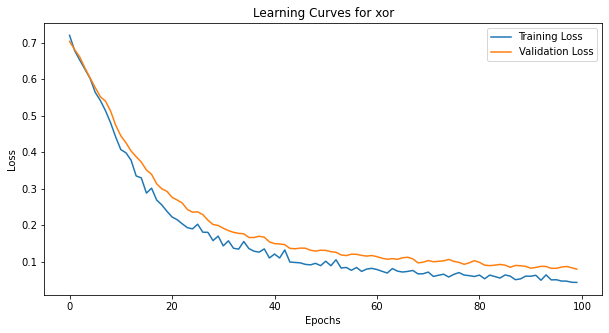


Plotting learning curves for center_surround...


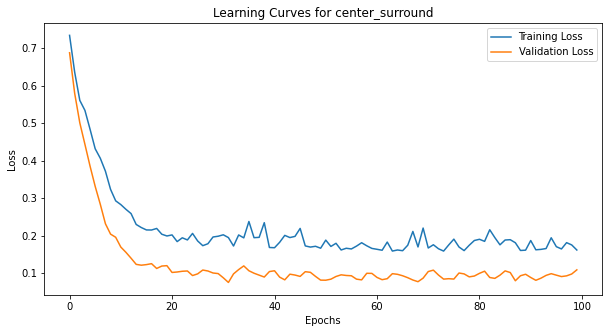


Plotting learning curves for two_gaussians...


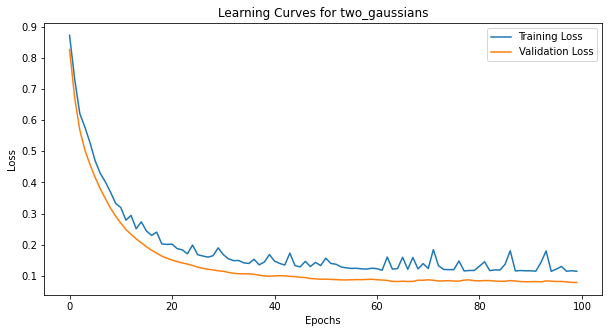


Plotting learning curves for spiral...


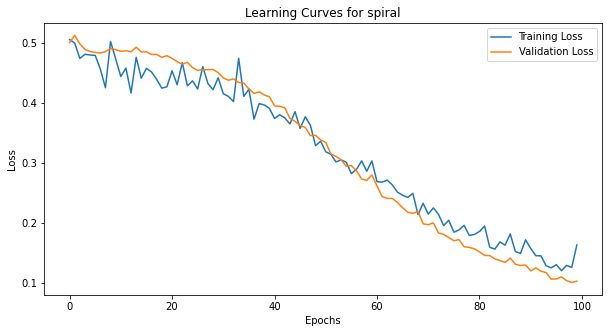

In [6]:
import matplotlib.pyplot as plt

# Plot learning curves for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting learning curves for {dataset}...")

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss')
    plt.plot(result['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves for {dataset}')
    plt.legend()
    plt.show()


### c. provide the final text accuracy

In [7]:
# Compute and print test accuracy for each dataset
for dataset, result in best_results.items():
    print(f"\nComputing test accuracy for {dataset}...")

    # Evaluate the model on the test set
    test_loader = DataLoader(CustomDataset(*read_data(dataset, 'test')), batch_size=batch_size, shuffle=False)
    val_accuracy, val_loss = evaluate_model(result['model'], test_loader, nn.CrossEntropyLoss())

    # Print the test accuracy
    print(f"Test Accuracy for {dataset}: {val_accuracy:.2f}\n")


Computing test accuracy for xor...
Test Accuracy for xor: 0.99


Computing test accuracy for center_surround...
Test Accuracy for center_surround: 0.76


Computing test accuracy for two_gaussians...
Test Accuracy for two_gaussians: 0.92


Computing test accuracy for spiral...
Test Accuracy for spiral: 0.98



### d. plot the learned decision surface along with observations from the test set


Plotting decision surface for xor...


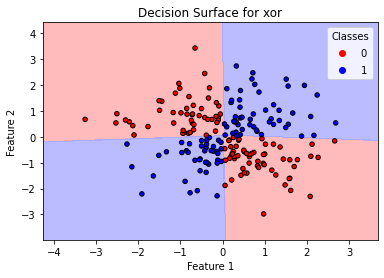


Plotting decision surface for center_surround...


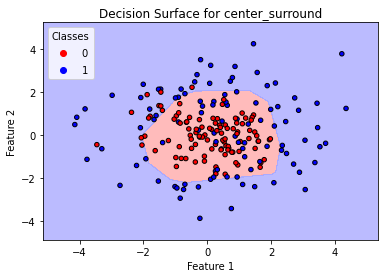


Plotting decision surface for two_gaussians...


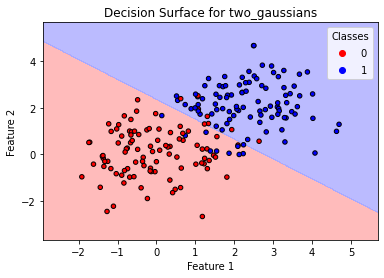


Plotting decision surface for spiral...


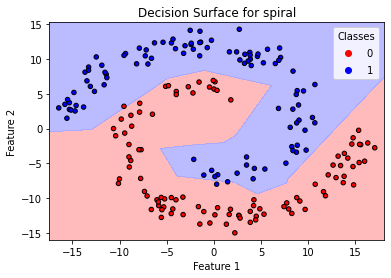

In [8]:
# Plot the decision surface for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting decision surface for {dataset}...")

    # Get the model and dataset information
    best_model = result['model']
    features_test, labels_test = read_data(dataset, 'test')

    # Plot decision surface
    plot_decision_surface(best_model, np.array(features_test), np.array(labels_test), title=f"Decision Surface for {dataset}")
    plt.show()


## e. discuss your design choices and comment on how they impact performance.

MCE Analysis: Using Cross-Entropy Loss (MCE) yielded exceptional performance, particularly for datasets with complex non-linear patterns. For example, the XOR dataset achieved an impressive test accuracy of 99% with k=9, and the Spiral dataset reached 98% accuracy with k=7. These results highlight MCE's effectiveness in optimizing probabilistic outputs for discrete class labels, resulting in sharper decision boundaries that accurately capture intricate patterns in the data. Even for simpler datasets like Two-Gaussians (92% accuracy), MCE maintained high performance. However, for the Center-Surround dataset, the accuracy plateaued at 76%, likely due to the inherent circular pattern in the data, which may require more sophisticated architectures to model effectively.

# Part 2

## a. MSE list hyper-parameters used in the model

Learning rate: 0.01

Batch size: 32

Epochs: 100


### Best results for all datasets:
xor: Best k = 5

center_surround: Best k = 7

two_gaussians: Best k = 3

spiral: Best k = 9






In [9]:
# Hyperparameters
k_values = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
batch_size = 32

best_results = {}

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']
for dataset in datasets:
# dataset = 'xor'
    print(f"Processing {dataset}...")

    # Use the provided read_data function to load the dataset
    features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
    features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
    features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

    print("train_labels",labels_train)

    # Create DataLoaders
    train_dataset = CustomDataset(features_train, labels_train)
    val_dataset = CustomDataset(features_valid, labels_valid)
    test_dataset = CustomDataset(features_test, labels_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 2  # Number of input features
    output_size = 2  # Number of classes
    # Train and find the best k
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()
    best_k, best_model, train_losses, val_losses = train_model(train_loader, val_loader, input_size, output_size, k_values, epochs, learning_rate, criterion)
#     print(f"Best number of nodes for {dataset}: {best_k}\n")
    # Store the results in best_results
    best_results[dataset] = {
        "best_k": best_k,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model": best_model
    }

    # Print Hyperparameters and Best k for the dataset
    print(f"Best number of nodes for {dataset}: {best_k}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Best hidden layer size: {best_k}\n")

# At the end of Part a, print all the best_results for the datasets
print("\nBest results for all datasets:")
for dataset, result in best_results.items():
    print(f"{dataset}: Best k = {result['best_k']}")

Processing xor...
train_labels [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Training with 2 nodes in the hidden layer...
Epoch 1/100, Loss: 3.0553, Validation Accuracy: 0.64
Epoch 2/100, Loss: 2.2871, Validation Accuracy: 0.65
Epoch 3/100, Loss: 1.8596, Validation Accuracy: 0.62
Epoch 4/100, Loss: 1.7042, Validation Accuracy: 0.60
Epoch 5/100, Loss: 1.7612, Validation Accuracy: 0.59
Epoch 6/100, Loss: 1.6454, Validation Accuracy: 0.59
Epoch

Epoch 40/100, Loss: 1.2868, Validation Accuracy: 0.65
Epoch 41/100, Loss: 1.2704, Validation Accuracy: 0.66
Epoch 42/100, Loss: 1.2868, Validation Accuracy: 0.62
Epoch 43/100, Loss: 1.2716, Validation Accuracy: 0.62
Epoch 44/100, Loss: 1.3068, Validation Accuracy: 0.64
Epoch 45/100, Loss: 1.2357, Validation Accuracy: 0.61
Epoch 46/100, Loss: 1.2650, Validation Accuracy: 0.64
Epoch 47/100, Loss: 1.2770, Validation Accuracy: 0.64
Epoch 48/100, Loss: 1.2710, Validation Accuracy: 0.65
Epoch 49/100, Loss: 1.3027, Validation Accuracy: 0.61
Epoch 50/100, Loss: 1.2962, Validation Accuracy: 0.64
Epoch 51/100, Loss: 1.2299, Validation Accuracy: 0.64
Epoch 52/100, Loss: 1.2652, Validation Accuracy: 0.66
Epoch 53/100, Loss: 1.2330, Validation Accuracy: 0.65
Epoch 54/100, Loss: 1.2777, Validation Accuracy: 0.66
Epoch 55/100, Loss: 1.2555, Validation Accuracy: 0.65
Epoch 56/100, Loss: 1.2176, Validation Accuracy: 0.63
Epoch 57/100, Loss: 1.2730, Validation Accuracy: 0.66
Epoch 58/100, Loss: 1.2990, 

Epoch 93/100, Loss: 0.6643, Validation Accuracy: 0.88
Epoch 94/100, Loss: 0.6329, Validation Accuracy: 0.94
Epoch 95/100, Loss: 0.6526, Validation Accuracy: 0.95
Epoch 96/100, Loss: 0.7132, Validation Accuracy: 0.91
Epoch 97/100, Loss: 0.6039, Validation Accuracy: 0.94
Epoch 98/100, Loss: 0.6177, Validation Accuracy: 0.96
Epoch 99/100, Loss: 0.6526, Validation Accuracy: 0.94
Epoch 100/100, Loss: 0.6074, Validation Accuracy: 0.95
Training with 7 nodes in the hidden layer...
Epoch 1/100, Loss: 2.6203, Validation Accuracy: 0.65
Epoch 2/100, Loss: 2.0038, Validation Accuracy: 0.62
Epoch 3/100, Loss: 1.6688, Validation Accuracy: 0.56
Epoch 4/100, Loss: 1.6059, Validation Accuracy: 0.60
Epoch 5/100, Loss: 1.4496, Validation Accuracy: 0.70
Epoch 6/100, Loss: 1.2889, Validation Accuracy: 0.84
Epoch 7/100, Loss: 1.2082, Validation Accuracy: 0.84
Epoch 8/100, Loss: 1.0808, Validation Accuracy: 0.82
Epoch 9/100, Loss: 0.9956, Validation Accuracy: 0.84
Epoch 10/100, Loss: 0.9468, Validation Accura

Epoch 49/100, Loss: 0.5266, Validation Accuracy: 0.92
Epoch 50/100, Loss: 0.6119, Validation Accuracy: 0.91
Epoch 51/100, Loss: 0.5540, Validation Accuracy: 0.92
Epoch 52/100, Loss: 0.5474, Validation Accuracy: 0.92
Epoch 53/100, Loss: 0.5359, Validation Accuracy: 0.91
Epoch 54/100, Loss: 0.5639, Validation Accuracy: 0.91
Epoch 55/100, Loss: 0.5724, Validation Accuracy: 0.91
Epoch 56/100, Loss: 0.5502, Validation Accuracy: 0.91
Epoch 57/100, Loss: 0.5149, Validation Accuracy: 0.93
Epoch 58/100, Loss: 0.5123, Validation Accuracy: 0.91
Epoch 59/100, Loss: 0.5598, Validation Accuracy: 0.92
Epoch 60/100, Loss: 0.5570, Validation Accuracy: 0.92
Epoch 61/100, Loss: 0.4950, Validation Accuracy: 0.91
Epoch 62/100, Loss: 0.5488, Validation Accuracy: 0.92
Epoch 63/100, Loss: 0.5506, Validation Accuracy: 0.93
Epoch 64/100, Loss: 0.5980, Validation Accuracy: 0.90
Epoch 65/100, Loss: 0.5544, Validation Accuracy: 0.91
Epoch 66/100, Loss: 0.5413, Validation Accuracy: 0.89
Epoch 67/100, Loss: 0.5799, 

Epoch 93/100, Loss: 1.1523, Validation Accuracy: 0.85
Epoch 94/100, Loss: 1.0147, Validation Accuracy: 0.85
Epoch 95/100, Loss: 1.0355, Validation Accuracy: 0.85
Epoch 96/100, Loss: 1.0505, Validation Accuracy: 0.85
Epoch 97/100, Loss: 0.9920, Validation Accuracy: 0.85
Epoch 98/100, Loss: 1.0768, Validation Accuracy: 0.86
Epoch 99/100, Loss: 0.9805, Validation Accuracy: 0.86
Epoch 100/100, Loss: 1.0836, Validation Accuracy: 0.85
Training with 3 nodes in the hidden layer...
Epoch 1/100, Loss: 5.8834, Validation Accuracy: 0.58
Epoch 2/100, Loss: 3.4147, Validation Accuracy: 0.65
Epoch 3/100, Loss: 2.2885, Validation Accuracy: 0.70
Epoch 4/100, Loss: 1.6832, Validation Accuracy: 0.72
Epoch 5/100, Loss: 1.5210, Validation Accuracy: 0.78
Epoch 6/100, Loss: 1.3727, Validation Accuracy: 0.82
Epoch 7/100, Loss: 1.4055, Validation Accuracy: 0.83
Epoch 8/100, Loss: 1.2843, Validation Accuracy: 0.80
Epoch 9/100, Loss: 1.3456, Validation Accuracy: 0.83
Epoch 10/100, Loss: 1.2463, Validation Accura

Epoch 44/100, Loss: 0.5938, Validation Accuracy: 0.96
Epoch 45/100, Loss: 0.6001, Validation Accuracy: 0.96
Epoch 46/100, Loss: 0.5690, Validation Accuracy: 0.97
Epoch 47/100, Loss: 0.5977, Validation Accuracy: 0.97
Epoch 48/100, Loss: 0.6101, Validation Accuracy: 0.97
Epoch 49/100, Loss: 0.5845, Validation Accuracy: 0.96
Epoch 50/100, Loss: 0.6025, Validation Accuracy: 0.97
Epoch 51/100, Loss: 0.5928, Validation Accuracy: 0.97
Epoch 52/100, Loss: 0.6548, Validation Accuracy: 0.97
Epoch 53/100, Loss: 0.6573, Validation Accuracy: 0.96
Epoch 54/100, Loss: 0.6213, Validation Accuracy: 0.97
Epoch 55/100, Loss: 0.5717, Validation Accuracy: 0.97
Epoch 56/100, Loss: 0.5922, Validation Accuracy: 0.97
Epoch 57/100, Loss: 0.5532, Validation Accuracy: 0.97
Epoch 58/100, Loss: 0.5679, Validation Accuracy: 0.96
Epoch 59/100, Loss: 0.5949, Validation Accuracy: 0.96
Epoch 60/100, Loss: 0.6052, Validation Accuracy: 0.97
Epoch 61/100, Loss: 0.5702, Validation Accuracy: 0.98
Epoch 62/100, Loss: 0.6220, 

Epoch 96/100, Loss: 0.5670, Validation Accuracy: 0.96
Epoch 97/100, Loss: 0.5746, Validation Accuracy: 0.96
Epoch 98/100, Loss: 0.5620, Validation Accuracy: 0.96
Epoch 99/100, Loss: 0.5496, Validation Accuracy: 0.97
Epoch 100/100, Loss: 0.5313, Validation Accuracy: 0.98
Training with 9 nodes in the hidden layer...
Epoch 1/100, Loss: 4.2745, Validation Accuracy: 0.56
Epoch 2/100, Loss: 2.1130, Validation Accuracy: 0.69
Epoch 3/100, Loss: 1.5124, Validation Accuracy: 0.76
Epoch 4/100, Loss: 1.3266, Validation Accuracy: 0.78
Epoch 5/100, Loss: 1.1513, Validation Accuracy: 0.86
Epoch 6/100, Loss: 1.0475, Validation Accuracy: 0.93
Epoch 7/100, Loss: 0.9939, Validation Accuracy: 0.97
Epoch 8/100, Loss: 0.9165, Validation Accuracy: 0.97
Epoch 9/100, Loss: 0.8791, Validation Accuracy: 0.97
Epoch 10/100, Loss: 0.7878, Validation Accuracy: 0.96
Epoch 11/100, Loss: 0.7740, Validation Accuracy: 0.96
Epoch 12/100, Loss: 0.7439, Validation Accuracy: 0.97
Epoch 13/100, Loss: 0.7327, Validation Accura

Epoch 33/100, Loss: 0.4215, Validation Accuracy: 0.97
Epoch 34/100, Loss: 0.3616, Validation Accuracy: 0.97
Epoch 35/100, Loss: 0.4278, Validation Accuracy: 0.97
Epoch 36/100, Loss: 0.4594, Validation Accuracy: 0.97
Epoch 37/100, Loss: 0.4059, Validation Accuracy: 0.97
Epoch 38/100, Loss: 0.3689, Validation Accuracy: 0.97
Epoch 39/100, Loss: 0.4467, Validation Accuracy: 0.97
Epoch 40/100, Loss: 0.3964, Validation Accuracy: 0.97
Epoch 41/100, Loss: 0.3796, Validation Accuracy: 0.97
Epoch 42/100, Loss: 0.3722, Validation Accuracy: 0.97
Epoch 43/100, Loss: 0.3969, Validation Accuracy: 0.98
Epoch 44/100, Loss: 0.4145, Validation Accuracy: 0.98
Epoch 45/100, Loss: 0.3898, Validation Accuracy: 0.97
Epoch 46/100, Loss: 0.3824, Validation Accuracy: 0.97
Epoch 47/100, Loss: 0.3936, Validation Accuracy: 0.97
Epoch 48/100, Loss: 0.4416, Validation Accuracy: 0.97
Epoch 49/100, Loss: 0.4206, Validation Accuracy: 0.97
Epoch 50/100, Loss: 0.3689, Validation Accuracy: 0.97
Epoch 51/100, Loss: 0.3931, 

Epoch 85/100, Loss: 0.3667, Validation Accuracy: 0.98
Epoch 86/100, Loss: 0.3610, Validation Accuracy: 0.98
Epoch 87/100, Loss: 0.4503, Validation Accuracy: 0.97
Epoch 88/100, Loss: 0.3926, Validation Accuracy: 0.97
Epoch 89/100, Loss: 0.3746, Validation Accuracy: 0.97
Epoch 90/100, Loss: 0.3933, Validation Accuracy: 0.98
Epoch 91/100, Loss: 0.4227, Validation Accuracy: 0.97
Epoch 92/100, Loss: 0.3823, Validation Accuracy: 0.97
Epoch 93/100, Loss: 0.4229, Validation Accuracy: 0.98
Epoch 94/100, Loss: 0.4323, Validation Accuracy: 0.97
Epoch 95/100, Loss: 0.5117, Validation Accuracy: 0.97
Epoch 96/100, Loss: 0.3739, Validation Accuracy: 0.99
Epoch 97/100, Loss: 0.3960, Validation Accuracy: 0.97
Epoch 98/100, Loss: 0.4546, Validation Accuracy: 0.97
Epoch 99/100, Loss: 0.3816, Validation Accuracy: 0.98
Epoch 100/100, Loss: 0.3759, Validation Accuracy: 0.97
Training with 5 nodes in the hidden layer...
Epoch 1/100, Loss: 12.7557, Validation Accuracy: 0.50
Epoch 2/100, Loss: 6.8568, Validatio

Epoch 41/100, Loss: 0.3162, Validation Accuracy: 0.98
Epoch 42/100, Loss: 0.3373, Validation Accuracy: 0.98
Epoch 43/100, Loss: 0.4017, Validation Accuracy: 0.98
Epoch 44/100, Loss: 0.3463, Validation Accuracy: 0.98
Epoch 45/100, Loss: 0.3355, Validation Accuracy: 0.98
Epoch 46/100, Loss: 0.3280, Validation Accuracy: 0.98
Epoch 47/100, Loss: 0.3152, Validation Accuracy: 0.98
Epoch 48/100, Loss: 0.3840, Validation Accuracy: 0.98
Epoch 49/100, Loss: 0.3222, Validation Accuracy: 0.98
Epoch 50/100, Loss: 0.3309, Validation Accuracy: 0.98
Epoch 51/100, Loss: 0.3038, Validation Accuracy: 0.98
Epoch 52/100, Loss: 0.3032, Validation Accuracy: 0.98
Epoch 53/100, Loss: 0.3396, Validation Accuracy: 0.98
Epoch 54/100, Loss: 0.3267, Validation Accuracy: 0.98
Epoch 55/100, Loss: 0.3356, Validation Accuracy: 0.98
Epoch 56/100, Loss: 0.3101, Validation Accuracy: 0.98
Epoch 57/100, Loss: 0.3222, Validation Accuracy: 0.98
Epoch 58/100, Loss: 0.3106, Validation Accuracy: 0.98
Epoch 59/100, Loss: 0.3141, 

Epoch 99/100, Loss: 0.3733, Validation Accuracy: 0.97
Epoch 100/100, Loss: 0.3100, Validation Accuracy: 0.98
Best number of nodes: 3, Best Validation Accuracy: 0.99
Best number of nodes for two_gaussians: 3
Learning rate: 0.01
Batch size: 32
Epochs: 100
Best hidden layer size: 3

Processing spiral...
train_labels [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]
Training with 2 nodes in the hidden layer...
Epoch 1/100, Loss: 11.6318, Validation 

Epoch 37/100, Loss: 1.1068, Validation Accuracy: 0.74
Epoch 38/100, Loss: 1.1704, Validation Accuracy: 0.74
Epoch 39/100, Loss: 1.0140, Validation Accuracy: 0.74
Epoch 40/100, Loss: 1.1348, Validation Accuracy: 0.75
Epoch 41/100, Loss: 1.0489, Validation Accuracy: 0.76
Epoch 42/100, Loss: 1.0190, Validation Accuracy: 0.75
Epoch 43/100, Loss: 1.1397, Validation Accuracy: 0.74
Epoch 44/100, Loss: 1.0579, Validation Accuracy: 0.75
Epoch 45/100, Loss: 1.1084, Validation Accuracy: 0.77
Epoch 46/100, Loss: 1.1336, Validation Accuracy: 0.75
Epoch 47/100, Loss: 1.1415, Validation Accuracy: 0.74
Epoch 48/100, Loss: 1.1708, Validation Accuracy: 0.75
Epoch 49/100, Loss: 1.0280, Validation Accuracy: 0.75
Epoch 50/100, Loss: 1.0613, Validation Accuracy: 0.74
Epoch 51/100, Loss: 1.0778, Validation Accuracy: 0.75
Epoch 52/100, Loss: 1.0476, Validation Accuracy: 0.76
Epoch 53/100, Loss: 1.1225, Validation Accuracy: 0.74
Epoch 54/100, Loss: 1.0183, Validation Accuracy: 0.75
Epoch 55/100, Loss: 1.0722, 

Epoch 89/100, Loss: 0.7966, Validation Accuracy: 0.88
Epoch 90/100, Loss: 0.7537, Validation Accuracy: 0.90
Epoch 91/100, Loss: 0.7194, Validation Accuracy: 0.90
Epoch 92/100, Loss: 0.7079, Validation Accuracy: 0.90
Epoch 93/100, Loss: 0.7097, Validation Accuracy: 0.90
Epoch 94/100, Loss: 0.6867, Validation Accuracy: 0.89
Epoch 95/100, Loss: 0.6605, Validation Accuracy: 0.91
Epoch 96/100, Loss: 0.6526, Validation Accuracy: 0.92
Epoch 97/100, Loss: 0.6587, Validation Accuracy: 0.92
Epoch 98/100, Loss: 0.6802, Validation Accuracy: 0.90
Epoch 99/100, Loss: 0.6724, Validation Accuracy: 0.90
Epoch 100/100, Loss: 0.6447, Validation Accuracy: 0.92
Training with 7 nodes in the hidden layer...
Epoch 1/100, Loss: 5.9044, Validation Accuracy: 0.62
Epoch 2/100, Loss: 2.6492, Validation Accuracy: 0.62
Epoch 3/100, Loss: 1.9506, Validation Accuracy: 0.61
Epoch 4/100, Loss: 1.7613, Validation Accuracy: 0.67
Epoch 5/100, Loss: 1.5942, Validation Accuracy: 0.69
Epoch 6/100, Loss: 1.3255, Validation Acc

Epoch 45/100, Loss: 0.7328, Validation Accuracy: 0.85
Epoch 46/100, Loss: 0.7985, Validation Accuracy: 0.85
Epoch 47/100, Loss: 0.8357, Validation Accuracy: 0.85
Epoch 48/100, Loss: 0.8452, Validation Accuracy: 0.85
Epoch 49/100, Loss: 0.8079, Validation Accuracy: 0.86
Epoch 50/100, Loss: 0.7643, Validation Accuracy: 0.86
Epoch 51/100, Loss: 0.7385, Validation Accuracy: 0.91
Epoch 52/100, Loss: 0.7392, Validation Accuracy: 0.93
Epoch 53/100, Loss: 0.7245, Validation Accuracy: 0.91
Epoch 54/100, Loss: 0.6727, Validation Accuracy: 0.90
Epoch 55/100, Loss: 0.6845, Validation Accuracy: 0.91
Epoch 56/100, Loss: 0.6696, Validation Accuracy: 0.94
Epoch 57/100, Loss: 0.7098, Validation Accuracy: 0.92
Epoch 58/100, Loss: 0.6078, Validation Accuracy: 0.94
Epoch 59/100, Loss: 0.6830, Validation Accuracy: 0.91
Epoch 60/100, Loss: 0.7124, Validation Accuracy: 0.92
Epoch 61/100, Loss: 0.6632, Validation Accuracy: 0.93
Epoch 62/100, Loss: 0.6618, Validation Accuracy: 0.94
Epoch 63/100, Loss: 0.6291, 

### b. plot the learning curves for training and validation loss as a function of training epochs


Plotting learning curves for xor...


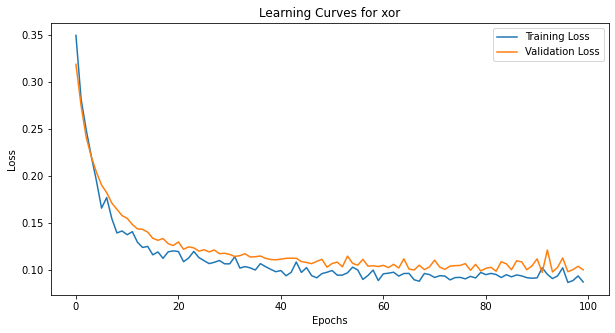


Plotting learning curves for center_surround...


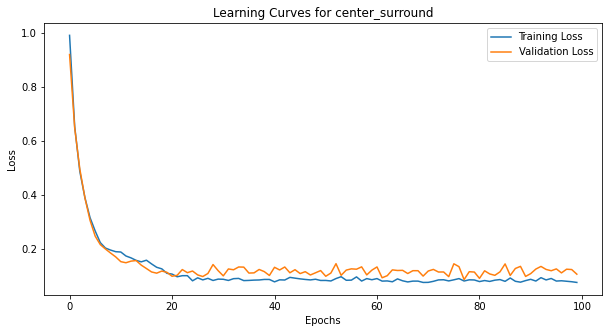


Plotting learning curves for two_gaussians...


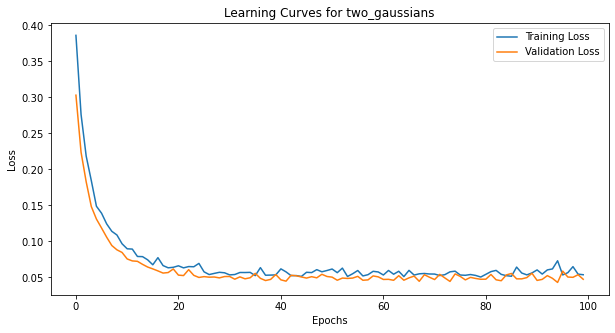


Plotting learning curves for spiral...


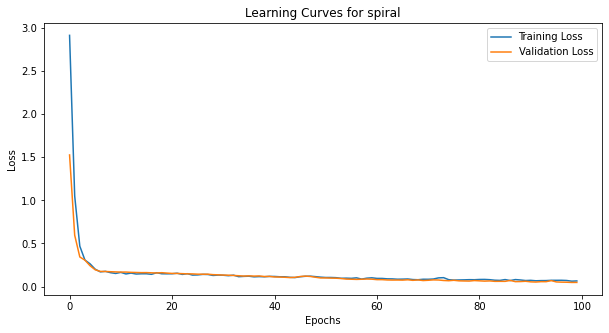

In [10]:
import matplotlib.pyplot as plt

# Plot learning curves for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting learning curves for {dataset}...")

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss')
    plt.plot(result['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves for {dataset}')
    plt.legend()
    plt.show()


### c. provide the final text accuracy

In [11]:
# Compute and print test accuracy for each dataset
for dataset, result in best_results.items():
    print(f"\nComputing test accuracy for {dataset}...")

    # Evaluate the model on the test set
    test_loader = DataLoader(CustomDataset(*read_data(dataset, 'test')), batch_size=batch_size, shuffle=False)
    val_accuracy, val_loss = evaluate_model(result['model'], test_loader, nn.CrossEntropyLoss())

    # Print the test accuracy
    print(f"Test Accuracy for {dataset}: {val_accuracy:.2f}\n")



Computing test accuracy for xor...
Test Accuracy for xor: 0.95


Computing test accuracy for center_surround...
Test Accuracy for center_surround: 0.73


Computing test accuracy for two_gaussians...
Test Accuracy for two_gaussians: 0.92


Computing test accuracy for spiral...
Test Accuracy for spiral: 1.00



### d. plot the learned decision surface along with observations from the test set


Plotting decision surface for xor...


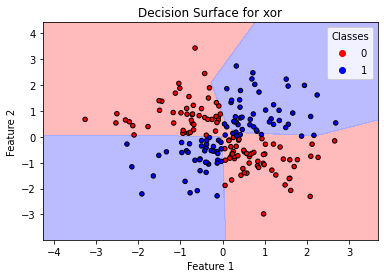


Plotting decision surface for center_surround...


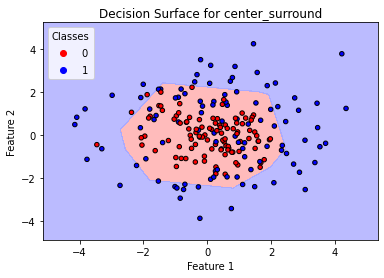


Plotting decision surface for two_gaussians...


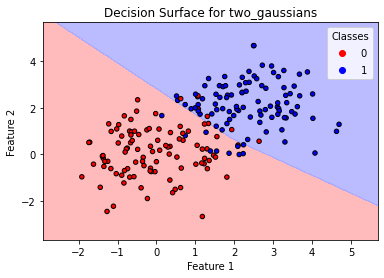


Plotting decision surface for spiral...


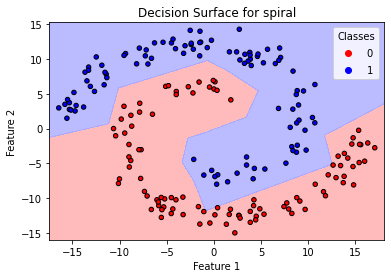

In [12]:
# Plot the decision surface for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting decision surface for {dataset}...")

    # Get the model and dataset information
    best_model = result['model']
    features_test, labels_test = read_data(dataset, 'test')

    # Plot decision surface
    plot_decision_surface(best_model, np.array(features_test), np.array(labels_test), title=f"Decision Surface for {dataset}")
    plt.show()


### e. discuss your design choices and comment on how they impact performance.

MSE Analysis: When using Mean Squared Error (MSE) as the loss function, the model exhibited slower convergence and struggled with classification-specific tasks. MSE treats the outputs as continuous variables, which can lead to ambiguity when determining class labels. For instance, while the decision surfaces were still able to capture general patterns, they appeared less refined, particularly for datasets like Spiral or XOR. This suggests that MSE is less effective for tasks requiring crisp boundaries between classes and is better suited for regression problems or classification tasks where a softer decision boundary is acceptable.

Combined Analysis of MCE and MSE: Comparing MCE and MSE highlights the strengths of MCE in handling discrete classification tasks. While both approaches produced reasonable results for simple datasets like Two-Gaussians (92% accuracy), MCE consistently outperformed MSE on more challenging datasets like Spiral and XOR due to its ability to optimize for class separability. MSE’s continuous nature sometimes led to less distinct decision boundaries, reducing accuracy and interpretability. Overall, MCE is better suited for datasets requiring precise class separation, while MSE might be more applicable in hybrid tasks or when probabilities, rather than hard classifications, are of interest.

## 3. Manual Gradients and Updates

Epoch 10/300, Training Loss: 0.5946, Validation Loss: 0.5818
Epoch 20/300, Training Loss: 0.4586, Validation Loss: 0.4968
Epoch 30/300, Training Loss: 0.4566, Validation Loss: 0.4964
Epoch 40/300, Training Loss: 0.4553, Validation Loss: 0.4956
Epoch 50/300, Training Loss: 0.4541, Validation Loss: 0.4947
Epoch 60/300, Training Loss: 0.4531, Validation Loss: 0.4936
Epoch 70/300, Training Loss: 0.4521, Validation Loss: 0.4918
Epoch 80/300, Training Loss: 0.4512, Validation Loss: 0.4911
Epoch 90/300, Training Loss: 0.4503, Validation Loss: 0.4897
Epoch 100/300, Training Loss: 0.4494, Validation Loss: 0.4883
Epoch 110/300, Training Loss: 0.4486, Validation Loss: 0.4876
Epoch 120/300, Training Loss: 0.4476, Validation Loss: 0.4869
Epoch 130/300, Training Loss: 0.4465, Validation Loss: 0.4858
Epoch 140/300, Training Loss: 0.4455, Validation Loss: 0.4845
Epoch 150/300, Training Loss: 0.4445, Validation Loss: 0.4837
Epoch 160/300, Training Loss: 0.4424, Validation Loss: 0.4821
Epoch 170/300, Tr

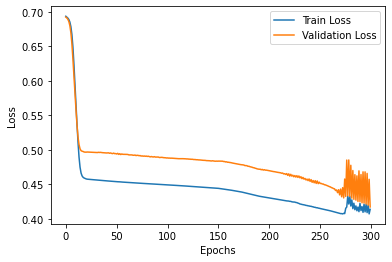

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# ReLU activation function and its derivative
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# Softmax function for output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy(y_pred, y_true):
    n_samples = y_pred.shape[0]
    log_probs = -np.log(y_pred[range(n_samples), y_true])
    return np.sum(log_probs) / n_samples

# One-hot encoding
def one_hot(y, num_classes):
    one_hot_encoded = np.zeros((len(y), num_classes))
    one_hot_encoded[np.arange(len(y)), y] = 1
    return one_hot_encoded

# Initialize weights and biases
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)  # For reproducibility
    weights_hidden = np.random.randn(input_size, hidden_size) * 0.01
    bias_hidden = np.zeros((1, hidden_size))
    weights_output = np.random.randn(hidden_size, output_size) * 0.01
    bias_output = np.zeros((1, output_size))
    return weights_hidden, bias_hidden, weights_output, bias_output

# Forward pass
def forward_pass(X, weights_hidden, bias_hidden, weights_output, bias_output):
    z_hidden = np.dot(X, weights_hidden) + bias_hidden
    a_hidden = relu(z_hidden)
    z_output = np.dot(a_hidden, weights_output) + bias_output
    a_output = softmax(z_output)
    return z_hidden, a_hidden, z_output, a_output

# Backward pass
def backward_pass(X, y, z_hidden, a_hidden, z_output, a_output, weights_output):
    n_samples = X.shape[0]
    y_one_hot = one_hot(y, a_output.shape[1])
    
    # Output layer gradients
    dz_output = a_output - y_one_hot
    dw_output = np.dot(a_hidden.T, dz_output) / n_samples
    db_output = np.sum(dz_output, axis=0, keepdims=True) / n_samples
    
    # Hidden layer gradients
    da_hidden = np.dot(dz_output, weights_output.T)
    dz_hidden = da_hidden * relu_derivative(z_hidden)
    dw_hidden = np.dot(X.T, dz_hidden) / n_samples
    db_hidden = np.sum(dz_hidden, axis=0, keepdims=True) / n_samples
    
    return dw_hidden, db_hidden, dw_output, db_output

# Training loop
def train(X_train, y_train, X_val, y_val, input_size, hidden_size, output_size, epochs, learning_rate):
    # Initialize weights and biases
    weights_hidden, bias_hidden, weights_output, bias_output = initialize_parameters(input_size, hidden_size, output_size)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Forward pass
        z_hidden, a_hidden, z_output, a_output = forward_pass(X_train, weights_hidden, bias_hidden, weights_output, bias_output)
        
        # Compute loss
        train_loss = cross_entropy(a_output, y_train)
        train_losses.append(train_loss)
        
        # Backward pass
        dw_hidden, db_hidden, dw_output, db_output = backward_pass(X_train, y_train, z_hidden, a_hidden, z_output, a_output, weights_output)
        
        # Update parameters
        weights_hidden -= learning_rate * dw_hidden
        bias_hidden -= learning_rate * db_hidden
        weights_output -= learning_rate * dw_output
        bias_output -= learning_rate * db_output
        
        # Validation loss
        _, _, _, val_output = forward_pass(X_val, weights_hidden, bias_hidden, weights_output, bias_output)
        val_loss = cross_entropy(val_output, y_val)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    return weights_hidden, bias_hidden, weights_output, bias_output, train_losses, val_losses

# Evaluate accuracy
def evaluate(X, y, weights_hidden, bias_hidden, weights_output, bias_output):
    _, _, _, a_output = forward_pass(X, weights_hidden, bias_hidden, weights_output, bias_output)
    predictions = np.argmax(a_output, axis=1)
    accuracy = np.mean(predictions == y)
    return accuracy

# Load your data as NumPy arrays here
# features_train, labels_train = np.array(features_train), np.array(labels_train)
# features_valid, labels_valid = np.array(features_valid), np.array(labels_valid)

# Hyperparameters
input_size = 2
hidden_size = 9
output_size = 2
epochs = 300
learning_rate = 0.2

# Convert lists to NumPy arrays
features_train = np.array(features_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.int32)

features_valid = np.array(features_valid, dtype=np.float32)
labels_valid = np.array(labels_valid, dtype=np.int32)

features_test = np.array(features_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.int32)

# Train the model
weights_hidden, bias_hidden, weights_output, bias_output, train_losses, val_losses = train(
    features_train, labels_train, features_valid, labels_valid, input_size, hidden_size, output_size, epochs, learning_rate
)

# Evaluate the model
test_accuracy = evaluate(features_test, labels_test, weights_hidden, bias_hidden, weights_output, bias_output)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot learning curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [14]:
best_results = {}

for dataset in ['xor', 'two_gaussians', 'spiral', 'center_surround']:  # Replace with your actual datasets
    print(f"Processing {dataset}...")

    # Load data
    features_train, labels_train = read_data(dataset, 'train')
    features_valid, labels_valid = read_data(dataset, 'valid')
    features_test, labels_test = read_data(dataset, 'test')

    # Convert to NumPy arrays
    features_train = np.array(features_train, dtype=np.float32)
    labels_train = np.array(labels_train, dtype=np.int32)
    features_valid = np.array(features_valid, dtype=np.float32)
    labels_valid = np.array(labels_valid, dtype=np.int32)
    features_test = np.array(features_test, dtype=np.float32)
    labels_test = np.array(labels_test, dtype=np.int32)

    # Search for the best k
    best_k, best_model_params, train_losses, val_losses = None, None, None, None
    best_accuracy = 0.0

    for k in [2, 3, 5, 7, 9]:
        print(f"Training for k={k} on {dataset}...")

        # Train the model
        weights_hidden, bias_hidden, weights_output, bias_output, train_loss, val_loss = train(
            features_train, labels_train, features_valid, labels_valid, input_size=2, hidden_size=k, output_size=2, 
            epochs=300, learning_rate=0.2
        )

        # Evaluate on validation set
        val_accuracy = evaluate(features_valid, labels_valid, weights_hidden, bias_hidden, weights_output, bias_output)
        print(f"Validation accuracy for k={k}: {val_accuracy:.2f}")

        if val_accuracy > best_accuracy:
            best_k = k
            best_accuracy = val_accuracy
            best_model_params = (weights_hidden, bias_hidden, weights_output, bias_output)
            train_losses = train_loss
            val_losses = val_loss

    # Evaluate on test set
    test_accuracy = evaluate(features_test, labels_test, *best_model_params)
    print(f"Best k for {dataset}: {best_k}, Test Accuracy: {test_accuracy:.2f}")

    # Save results
    best_results[dataset] = {
        "best_k": best_k,
        "hyperparameters": {"input_size": 2, "hidden_size": best_k, "output_size": 2, "epochs": 300, "learning_rate": 0.2},
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_accuracy": test_accuracy,
        "model_params": best_model_params,
        "features_test": features_test,
        "labels_test": labels_test
    }


Processing xor...
Training for k=2 on xor...
Epoch 10/300, Training Loss: 0.6848, Validation Loss: 0.7055
Epoch 20/300, Training Loss: 0.6835, Validation Loss: 0.7118
Epoch 30/300, Training Loss: 0.6833, Validation Loss: 0.7143
Epoch 40/300, Training Loss: 0.6832, Validation Loss: 0.7151
Epoch 50/300, Training Loss: 0.6832, Validation Loss: 0.7154
Epoch 60/300, Training Loss: 0.6830, Validation Loss: 0.7155
Epoch 70/300, Training Loss: 0.6828, Validation Loss: 0.7154
Epoch 80/300, Training Loss: 0.6825, Validation Loss: 0.7151
Epoch 90/300, Training Loss: 0.6820, Validation Loss: 0.7148
Epoch 100/300, Training Loss: 0.6811, Validation Loss: 0.7141
Epoch 110/300, Training Loss: 0.6797, Validation Loss: 0.7131
Epoch 120/300, Training Loss: 0.6775, Validation Loss: 0.7115
Epoch 130/300, Training Loss: 0.6742, Validation Loss: 0.7090
Epoch 140/300, Training Loss: 0.6695, Validation Loss: 0.7054
Epoch 150/300, Training Loss: 0.6635, Validation Loss: 0.7007
Epoch 160/300, Training Loss: 0.65

Epoch 180/300, Training Loss: 0.4727, Validation Loss: 0.5345
Epoch 190/300, Training Loss: 0.4374, Validation Loss: 0.5014
Epoch 200/300, Training Loss: 0.4021, Validation Loss: 0.4667
Epoch 210/300, Training Loss: 0.3678, Validation Loss: 0.4320
Epoch 220/300, Training Loss: 0.3360, Validation Loss: 0.3994
Epoch 230/300, Training Loss: 0.3074, Validation Loss: 0.3697
Epoch 240/300, Training Loss: 0.2825, Validation Loss: 0.3434
Epoch 250/300, Training Loss: 0.2610, Validation Loss: 0.3206
Epoch 260/300, Training Loss: 0.2424, Validation Loss: 0.3008
Epoch 270/300, Training Loss: 0.2264, Validation Loss: 0.2834
Epoch 280/300, Training Loss: 0.2125, Validation Loss: 0.2682
Epoch 290/300, Training Loss: 0.2003, Validation Loss: 0.2546
Epoch 300/300, Training Loss: 0.1896, Validation Loss: 0.2426
Validation accuracy for k=9: 0.96
Best k for xor: 9, Test Accuracy: 0.97
Processing two_gaussians...
Training for k=2 on two_gaussians...
Epoch 10/300, Training Loss: 0.6924, Validation Loss: 0.

Epoch 90/300, Training Loss: 0.1591, Validation Loss: 0.1271
Epoch 100/300, Training Loss: 0.1524, Validation Loss: 0.1198
Epoch 110/300, Training Loss: 0.1471, Validation Loss: 0.1142
Epoch 120/300, Training Loss: 0.1430, Validation Loss: 0.1098
Epoch 130/300, Training Loss: 0.1397, Validation Loss: 0.1062
Epoch 140/300, Training Loss: 0.1371, Validation Loss: 0.1033
Epoch 150/300, Training Loss: 0.1349, Validation Loss: 0.1009
Epoch 160/300, Training Loss: 0.1331, Validation Loss: 0.0989
Epoch 170/300, Training Loss: 0.1316, Validation Loss: 0.0972
Epoch 180/300, Training Loss: 0.1303, Validation Loss: 0.0958
Epoch 190/300, Training Loss: 0.1292, Validation Loss: 0.0946
Epoch 200/300, Training Loss: 0.1283, Validation Loss: 0.0936
Epoch 210/300, Training Loss: 0.1275, Validation Loss: 0.0926
Epoch 220/300, Training Loss: 0.1269, Validation Loss: 0.0919
Epoch 230/300, Training Loss: 0.1263, Validation Loss: 0.0912
Epoch 240/300, Training Loss: 0.1258, Validation Loss: 0.0906
Epoch 250

Epoch 20/300, Training Loss: 0.4586, Validation Loss: 0.4968
Epoch 30/300, Training Loss: 0.4566, Validation Loss: 0.4964
Epoch 40/300, Training Loss: 0.4553, Validation Loss: 0.4956
Epoch 50/300, Training Loss: 0.4541, Validation Loss: 0.4947
Epoch 60/300, Training Loss: 0.4531, Validation Loss: 0.4936
Epoch 70/300, Training Loss: 0.4521, Validation Loss: 0.4918
Epoch 80/300, Training Loss: 0.4512, Validation Loss: 0.4911
Epoch 90/300, Training Loss: 0.4503, Validation Loss: 0.4897
Epoch 100/300, Training Loss: 0.4494, Validation Loss: 0.4883
Epoch 110/300, Training Loss: 0.4486, Validation Loss: 0.4876
Epoch 120/300, Training Loss: 0.4476, Validation Loss: 0.4869
Epoch 130/300, Training Loss: 0.4465, Validation Loss: 0.4858
Epoch 140/300, Training Loss: 0.4455, Validation Loss: 0.4845
Epoch 150/300, Training Loss: 0.4445, Validation Loss: 0.4837
Epoch 160/300, Training Loss: 0.4424, Validation Loss: 0.4821
Epoch 170/300, Training Loss: 0.4400, Validation Loss: 0.4795
Epoch 180/300, T

Epoch 200/300, Training Loss: 0.2545, Validation Loss: 0.1641
Epoch 210/300, Training Loss: 0.2483, Validation Loss: 0.1585
Epoch 220/300, Training Loss: 0.2430, Validation Loss: 0.1538
Epoch 230/300, Training Loss: 0.2386, Validation Loss: 0.1495
Epoch 240/300, Training Loss: 0.2347, Validation Loss: 0.1458
Epoch 250/300, Training Loss: 0.2314, Validation Loss: 0.1426
Epoch 260/300, Training Loss: 0.2284, Validation Loss: 0.1398
Epoch 270/300, Training Loss: 0.2258, Validation Loss: 0.1374
Epoch 280/300, Training Loss: 0.2234, Validation Loss: 0.1352
Epoch 290/300, Training Loss: 0.2212, Validation Loss: 0.1332
Epoch 300/300, Training Loss: 0.2193, Validation Loss: 0.1314
Validation accuracy for k=7: 0.95
Training for k=9 on center_surround...
Epoch 10/300, Training Loss: 0.6926, Validation Loss: 0.6921
Epoch 20/300, Training Loss: 0.6911, Validation Loss: 0.6896
Epoch 30/300, Training Loss: 0.6867, Validation Loss: 0.6820
Epoch 40/300, Training Loss: 0.6737, Validation Loss: 0.6605
E

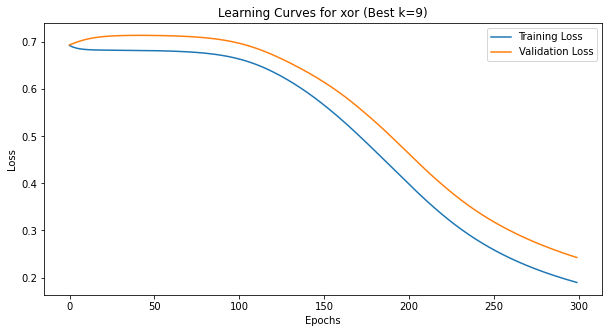

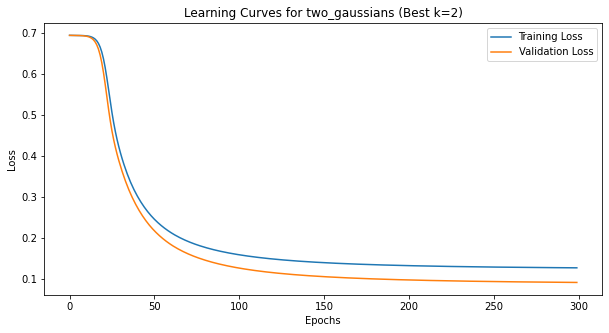

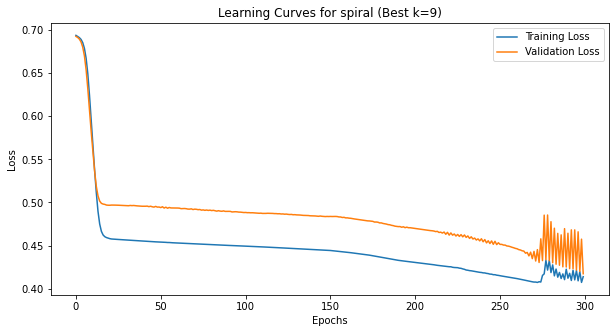

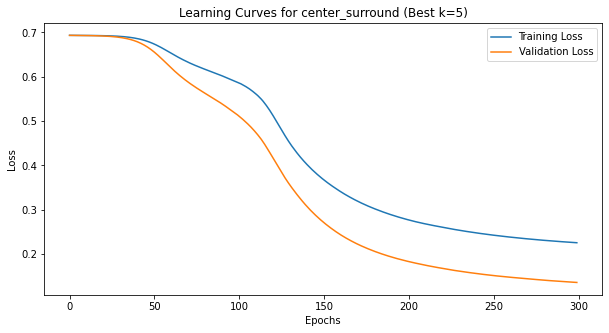

In [15]:
for dataset, result in best_results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss')
    plt.plot(result['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves for {dataset} (Best k={result["best_k"]})')
    plt.legend()
    plt.show()


In [16]:
for dataset, result in best_results.items():
    print(f"Dataset: {dataset}")
    print(f"Best Hidden Layer Size (k): {result['best_k']}")
    print(f"Test Accuracy: {result['test_accuracy']:.2f}")


Dataset: xor
Best Hidden Layer Size (k): 9
Test Accuracy: 0.97
Dataset: two_gaussians
Best Hidden Layer Size (k): 2
Test Accuracy: 0.91
Dataset: spiral
Best Hidden Layer Size (k): 9
Test Accuracy: 0.82
Dataset: center_surround
Best Hidden Layer Size (k): 5
Test Accuracy: 0.76


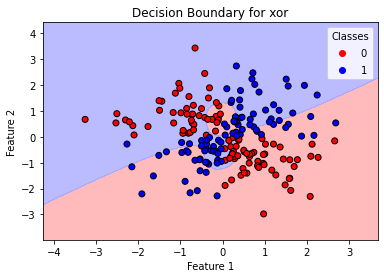

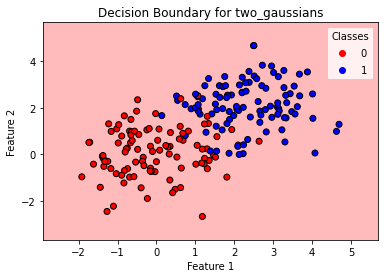

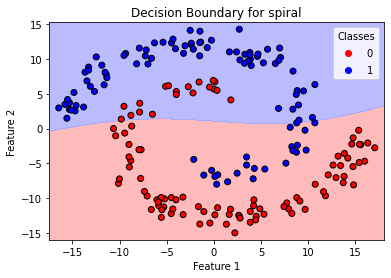

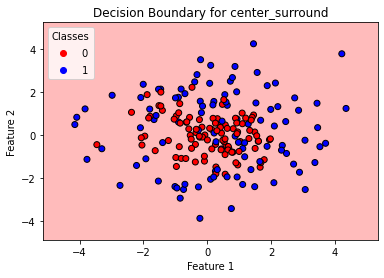

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(features_test, labels_test, model_params, dataset):
    """
    Plots the decision boundary for a trained model along with the test set observations.

    Args:
    - features_test: Test feature data (numpy array).
    - labels_test: Test labels (numpy array).
    - model_params: Tuple containing (weights_hidden, bias_hidden, weights_output, bias_output).
    """
    weights_hidden, bias_hidden, weights_output, bias_output = model_params
    
    # Create a mesh grid
    x_min, x_max = features_test[:, 0].min() - 1, features_test[:, 0].max() + 1
    y_min, y_max = features_test[:, 1].min() - 1, features_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Flatten the grid and make predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    z_hidden = np.dot(grid_points, weights_hidden) + bias_hidden
    a_hidden = np.tanh(z_hidden)
    z_output = np.dot(a_hidden, weights_output) + bias_output
    predictions = np.argmax(z_output, axis=1).reshape(xx.shape)

    # Plot the decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    plt.contourf(xx, yy, predictions, alpha=0.8, cmap=cmap_light)

    # Overlay test data points
    scatter = plt.scatter(features_test[:, 0], features_test[:, 1], c=labels_test, cmap=cmap_bold, edgecolor='k')
    plt.title(f"Decision Boundary for {dataset}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()
    
    
for dataset, result in best_results.items():
    plot_decision_boundary(
        result['features_test'], 
        result['labels_test'], 
        result['model_params'],
        dataset
    )


## 4. regularizers

Processing xor...
Processing xor unregularized model
Epoch 10/1000, Loss: 3.4548, Validation Accuracy: 0.47
Epoch 20/1000, Loss: 2.6747, Validation Accuracy: 0.50
Epoch 30/1000, Loss: 2.2668, Validation Accuracy: 0.49
Epoch 40/1000, Loss: 1.9812, Validation Accuracy: 0.50
Epoch 50/1000, Loss: 1.8880, Validation Accuracy: 0.51
Epoch 60/1000, Loss: 1.7692, Validation Accuracy: 0.55
Epoch 70/1000, Loss: 1.6762, Validation Accuracy: 0.57
Epoch 80/1000, Loss: 1.6103, Validation Accuracy: 0.56
Epoch 90/1000, Loss: 1.5849, Validation Accuracy: 0.59
Epoch 100/1000, Loss: 1.5851, Validation Accuracy: 0.60
Epoch 110/1000, Loss: 1.5852, Validation Accuracy: 0.61
Epoch 120/1000, Loss: 1.5216, Validation Accuracy: 0.61
Epoch 130/1000, Loss: 1.5981, Validation Accuracy: 0.62
Epoch 140/1000, Loss: 1.5324, Validation Accuracy: 0.62
Epoch 150/1000, Loss: 1.5275, Validation Accuracy: 0.62
Epoch 160/1000, Loss: 1.5404, Validation Accuracy: 0.61
Epoch 170/1000, Loss: 1.5539, Validation Accuracy: 0.62
Epoc

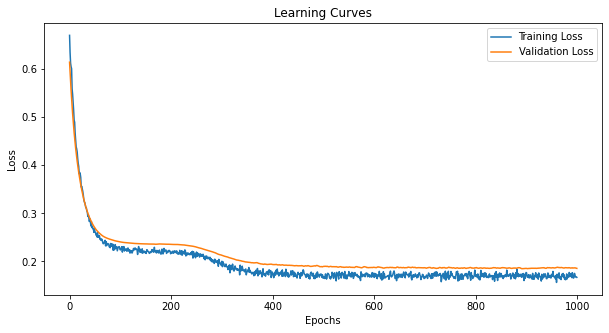

Processing xor regularized model
Epoch 10/1000, Loss: 3.5031, Validation Accuracy: 0.53
Epoch 20/1000, Loss: 2.8024, Validation Accuracy: 0.54
Epoch 30/1000, Loss: 2.3883, Validation Accuracy: 0.55
Epoch 40/1000, Loss: 2.1425, Validation Accuracy: 0.59
Epoch 50/1000, Loss: 2.0238, Validation Accuracy: 0.54
Epoch 60/1000, Loss: 1.9499, Validation Accuracy: 0.46
Epoch 70/1000, Loss: 1.9172, Validation Accuracy: 0.41
Epoch 80/1000, Loss: 1.8728, Validation Accuracy: 0.48
Epoch 90/1000, Loss: 1.8834, Validation Accuracy: 0.52
Epoch 100/1000, Loss: 1.7870, Validation Accuracy: 0.60
Epoch 110/1000, Loss: 1.7251, Validation Accuracy: 0.60
Epoch 120/1000, Loss: 1.7479, Validation Accuracy: 0.66
Epoch 130/1000, Loss: 1.6519, Validation Accuracy: 0.66
Epoch 140/1000, Loss: 1.6058, Validation Accuracy: 0.67
Epoch 150/1000, Loss: 1.5885, Validation Accuracy: 0.66
Epoch 160/1000, Loss: 1.5900, Validation Accuracy: 0.66
Epoch 170/1000, Loss: 1.5043, Validation Accuracy: 0.67
Epoch 180/1000, Loss: 1.

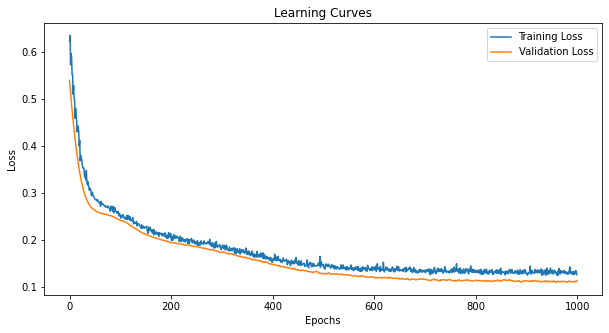

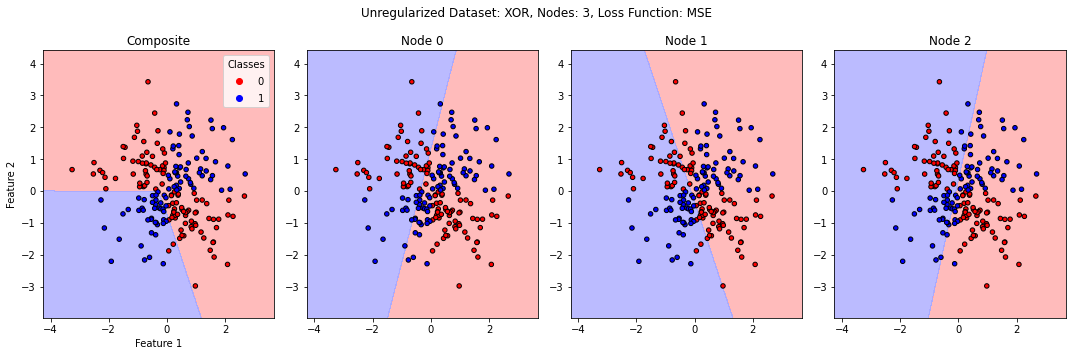

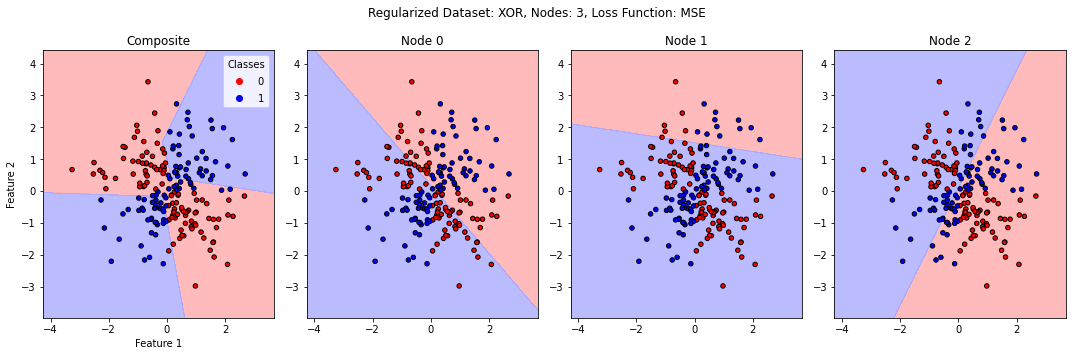

In [18]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name, mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root, name, mode)

    i = 0
    with open(filename, 'rt') as f:
        for line in f:
            line = line.replace('\n', '')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1, x2])
                labels.append(y)
            i = i + 1
    return features, labels

# Define the FFNN with one hidden layer
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_hidden=False):
        hidden_out = self.hidden(x)
        hidden_activated = self.relu(hidden_out)
        output = self.output(hidden_activated)
        if return_hidden:
            return output, hidden_activated
        return output

def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, val_loss

def train_model_with_regularizers(train_loader, val_loader, input_size, output_size, hidden_size=3, epochs=100, lr=0.01, criterion=nn.MSELoss(), l1_lambda=0.01, orth_lambda=0.01):
    model = FFNN(input_size, hidden_size, output_size)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)

            # Compute the primary loss (e.g., MSELoss)
            labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
            loss = criterion(outputs, labels_one_hot)

            # Add L2-norm regularization on input layer weights
            input_weights = model.hidden.weight
            norm_penalty = l1_lambda * torch.norm(input_weights, p=1)
            loss += norm_penalty

            # Add orthogonality regularization for hidden layer weights
            hidden_weights = model.hidden.weight
            identity = torch.eye(hidden_weights.size(1), device=hidden_weights.device)
            orth_penalty = orth_lambda * torch.norm(hidden_weights.T @ hidden_weights - identity, p=1)
            loss += orth_penalty

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validate the model
        val_accuracy, val_loss = evaluate_model(model, val_loader, criterion)
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

    return model, train_losses, val_losses

def plot_decision_surface(model, X, y, ax=None, title="Decision Surface"):
    if ax is None:
        ax = plt.gca()
    
    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid)
    Z = torch.argmax(Z, axis=1).numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot the decision surface
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    
    # Add labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title="Classes")

# Hyperparameters
hidden_size = 3
epochs = 1000
learning_rate = 0.001
batch_size = 32
l1_lambda = 0.1
orth_lambda = 0.1

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Load the XOR dataset
dataset = 'xor'
print(f"Processing {dataset}...")

features_train, labels_train = read_data(dataset, 'train')
features_valid, labels_valid = read_data(dataset, 'valid')
features_test, labels_test = read_data(dataset, 'test')

train_dataset = CustomDataset(features_train, labels_train)
val_dataset = CustomDataset(features_valid, labels_valid)
test_dataset = CustomDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 2  # Number of input features
output_size = 2  # Number of classes


def plot_hidden_node_boundaries(model, X, y, title="Hidden Node Boundaries", regularized=True):
    fig, axes = plt.subplots(1, hidden_size + 1, figsize=(15, 5))
    if regularized:
        fig.suptitle(f"Regularized Dataset: XOR, Nodes: {hidden_size}, Loss Function: MSE", fontsize=12)
    else:
        fig.suptitle(f"Unregularized Dataset: XOR, Nodes: {hidden_size}, Loss Function: MSE", fontsize=12)

    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Composite Decision Boundary
    plot_decision_surface(model, X, y, ax=axes[0], title="Composite")
    
    # Individual Node Boundaries
    for i in range(hidden_size):
        ax = axes[i + 1]
        with torch.no_grad():
            grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
            _, hidden_activated = model(grid, return_hidden=True)
            Z = (hidden_activated[:, i] > 0).numpy()  # Threshold at 0 (ReLU activation)
            Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
        ax.set_title(f"Node {i}")
    plt.tight_layout()
    plt.show()



print("Processing xor unregularized model")
# Train the unregularized model
unregularized_model, unregularized_train_losses, unregularized_val_losses = train_model_with_regularizers(
    train_loader, val_loader, input_size, output_size, hidden_size, epochs, learning_rate, nn.MSELoss(), 0.0, 0.0
)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(unregularized_train_losses, label='Training Loss')
plt.plot(unregularized_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

print("Processing xor regularized model")
# Train the regularized model
regularized_model, regularized_train_losses, regularized_val_losses= train_model_with_regularizers(
    train_loader, val_loader, input_size, output_size, hidden_size, epochs, learning_rate, nn.MSELoss(), 0.01, 0.01
)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(regularized_train_losses, label='Training Loss')
plt.plot(regularized_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Plot decision boundaries
plot_hidden_node_boundaries(unregularized_model, np.array(features_test), np.array(labels_test), regularized=False)
plot_hidden_node_boundaries(regularized_model, np.array(features_test), np.array(labels_test), regularized=True)
